In [1]:
import pandas as pd
import numpy as np
import itertools
import os
import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


sns.set(font_scale=1.4)

In [2]:
path = "./results"

def load_experiment_results(path, experiment_dir, filename):
    
    path = os.path.join(path,experiment_dir)

    directory = os.fsencode(path)
    df_full = None

    for file in os.listdir(directory):
        fn = os.fsdecode(file)
        if fn.find(filename) != -1: 

            df = pd.read_csv(os.path.join(path, fn))

            if len(df) == 1:
                continue

            #print(fn)
            if df_full is None:
                df_full = df
            else:
                df_full=  pd.concat([df_full, df])
        else:
            print("file ignored:", fn)
    
    return df_full

In [3]:

def get_ap_df(model_train_size):
    with open(f"./results/maps_{model_train_size}.txt","r") as file:
        js_obj = json.load(file)

    records = [{"image_id":key, "segm_ap": js_obj[key]["segm"]["AP"] }for key in js_obj.keys()]
    df = pd.DataFrame.from_records(records)
    df["model_train_size"] = model_train_size
    
    return df

def latex_pd(df):
    df = df.round(3)
    return df.to_latex(index=False)

In [4]:

def get_experiment(path, experiment_dir, filename,  agg_cols):
    
    
    agg_cols_wio_train = list(set(agg_cols) - set(["model_train_size"]))
    
    tta_gs_df = load_experiment_results(path, experiment_dir, filename)

    
    print(tta_gs_df["model_train_size"].unique())
    #tta_gs_df = tta_gs_df[tta_gs_df["model_train_size"] != 15]
    
    if len(tta_gs_df) == 0:
        print("error in import")
        return
    
    df_ap = None
    for model_train_size in [15, 240, 3000, 5800]:
        df = get_ap_df(model_train_size)
        if df_ap is None:
            df_ap = df
        else:
            df_ap =  pd.concat([df_ap, df])
    
    
    tta_gs_df =  pd.merge(
        tta_gs_df,
        df_ap,
        how="inner",
        on=["model_train_size","image_id"])


    tta_gs_df["certainty"] = 1 - tta_gs_df["agg_uncertainty"]
    tta_gs_df["ap_scale"] = tta_gs_df["segm_ap"]/100

    tta_gs_df["neg_conf_gap"] = (tta_gs_df["ap_scale"] - tta_gs_df["certainty"]) * (tta_gs_df["ap_scale"] - tta_gs_df["certainty"] < 0)


    


    records = []

    agg_cols_values = [tta_gs_df[col_name].unique() for col_name in agg_cols]
    for element in itertools.product(*agg_cols_values):
        tmp_df = tta_gs_df.copy()
        for col in agg_cols:
            tmp_df = tmp_df[tmp_df[col] == element[agg_cols.index(col)]]

        record = {col:tmp_df[col].values[0] for col in agg_cols}

        record["corr"] = tmp_df[["certainty", "ap_scale"]].corr()["certainty"]["ap_scale"]
        record["neg_conf_gap"] = tmp_df["neg_conf_gap"].sum()
             
        quant = 0.25
        
        intersection = len(set(tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(quant)]["image_id"].values).intersection(set(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(quant)]["image_id"].values)))
        union = len(set(tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(quant)]["image_id"].values).union(set(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(quant)]["image_id"].values)))
        record["quant_iou"] = intersection/union
        
        
        
        
        #(tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(.5)]["ap_scale"].mean() - tmp_df["ap_scale"].mean()) / (tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(.5)]["ap_scale"].mean()- tmp_df["ap_scale"].mean())
        
        #record["u_worst_map"] = (tmp_df[tmp_df["ap_scale"] < tmp_df["ap_scale"].quantile(.5)]["certainty"].mean() - tmp_df["certainty"].mean()) / (tmp_df[tmp_df["certainty"] < tmp_df["certainty"].quantile(.5)]["certainty"].mean()- tmp_df["certainty"].mean())
        


        #print(record)    
        records.append(record)


    df = pd.DataFrame.from_records(records)

    print(df.sort_values(by=["corr"], ascending=False), "\n")
    print(df.sort_values(by=["neg_conf_gap"], ascending=False))
    
    
    print(latex_pd(df.groupby(agg_cols_wio_train).mean().reset_index().sort_values(by=["corr"], ascending=False)[agg_cols_wio_train + ["corr", "quant_iou"]]), "\n")

    for col in agg_cols:
        print(latex_pd(df.groupby(col).mean().reset_index().sort_values(by=["corr"], ascending=False)[[col, "corr", "quant_iou"]]), "\n")


    
    agg_cols_values = [tta_gs_df[col_name].unique() for col_name in agg_cols_wio_train if col_name != "model_train_size"]
    print(agg_cols_values)

    for element in itertools.product(*agg_cols_values):
        tmp_df = tta_gs_df.copy()
        for col in agg_cols_wio_train:
            tmp_df = tmp_df[tmp_df[col] == element[agg_cols_wio_train.index(col)]]


        tmp_df["Certainty"] = tmp_df["certainty"]
        tmp_df["Normalized mAP"] = tmp_df["ap_scale"]
        tmp_df["Size of training data set"] = tmp_df["model_train_size"]

        print({col:tmp_df[col].values[0] for col in agg_cols_wio_train})
        myplot = sns.lmplot(data=tmp_df, x="Certainty", y="Normalized mAP", ci=None, col='Size of training data set', line_kws={'color': 'orange'}, col_wrap=2, hue="is_train")
        plt.show()
        
        


In [7]:

experiment_dir="mc_drop_known_vs_unknown"
filename = "results"
agg_cols = ["is_train", "model_train_size"]


df = load_experiment_results(path, experiment_dir, filename)

print(df.groupby("is_train").mean())


df.sort_values("agg_uncertainty").tail()

          Unnamed: 0  num_mc_samples  dropout_prob  model_train_size  run_id  \
is_train                                                                       
0               24.5            10.0          0.35             200.0     0.0   
1               74.5            10.0          0.35             200.0     0.0   

          agg_uncertainty  
is_train                   
0                0.393755  
1                0.348891  


/tmp/ipykernel_11668/1974352351.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby("is_train").mean())


,Unnamed: 0,num_mc_samples,dropout_prob,model_train_size,image_id,run_id,agg_uncertainty,is_train
78,78,10,0.35,200,acdc_data2_kurt_306-3_20_20201105_pos_5_0,0,0.514376,1
56,56,10,0.35,200,acdc_data3_20211029_pos_24_16,0,0.525405,1
27,27,10,0.35,200,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...,0,0.535904,0
68,68,10,0.35,200,acdc_data3_20211029_pos_15_138,0,0.564403,1
21,21,10,0.35,200,acdc_data2_F016_pos_3_51,0,0.569356,0


file ignored: .ipynb_checkpoints
      cut   agg  mask_iou  model_train_size      corr  neg_conf_gap  \
31  False   sum     False                15  0.504151      0.000000   
3    True   sum      True                15  0.478053      0.000000   
27  False   sum      True                15  0.474688      0.000000   
7    True   sum     False                15  0.460003      0.000000   
16   True  mean      True               240  0.377974     -8.484833   
40  False  mean      True               240  0.341882     -3.107751   
41  False  mean      True              3000  0.328044     -2.756210   
13   True   max     False              3000  0.316415     -1.264323   
45  False  mean     False              3000  0.313565     -1.970814   
37  False   max     False              3000  0.305665     -0.394828   
20   True  mean     False               240  0.302307     -7.101055   
44  False  mean     False               240  0.291754     -1.811855   
17   True  mean      True              3000 

/tmp/ipykernel_789873/3193485491.py:74: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby(col).mean().reset_index().sort_values(by=["corr"], ascending=False), "\n")
/tmp/ipykernel_789873/3193485491.py:74: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby(col).mean().reset_index().sort_values(by=["corr"], ascending=False), "\n")
/tmp/ipykernel_789873/3193485491.py:74: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid

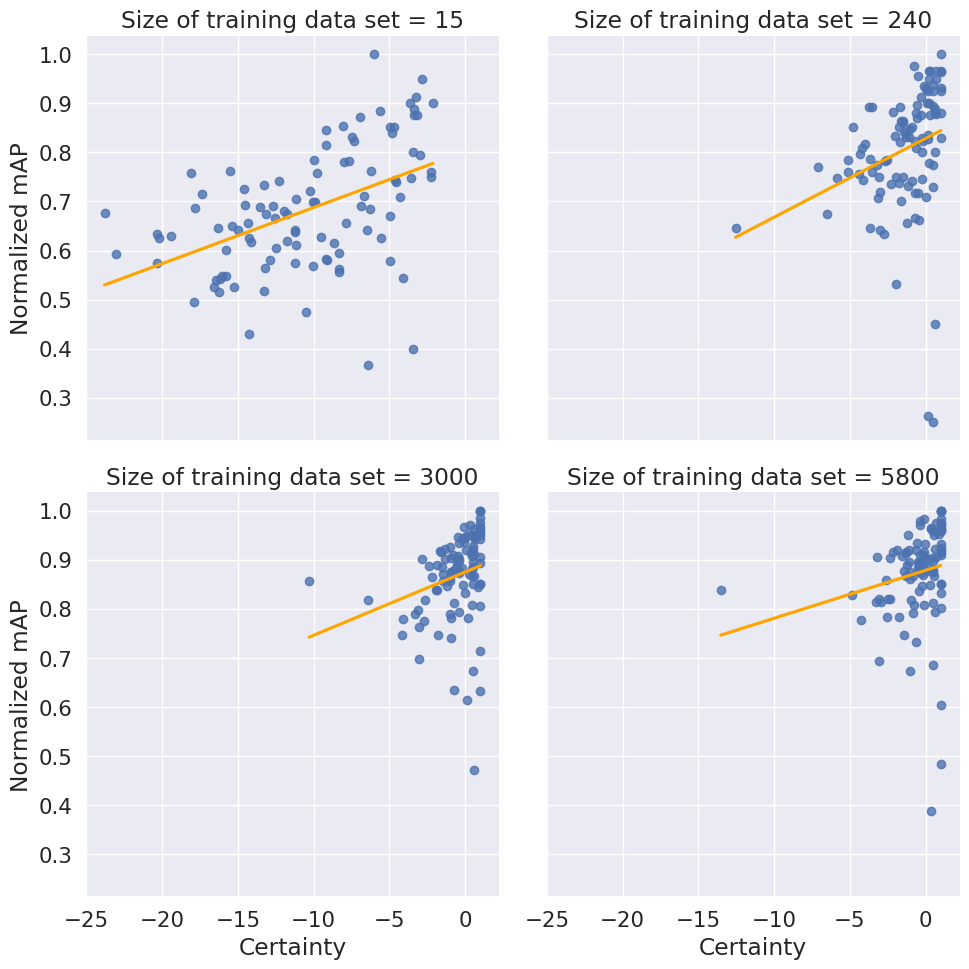

{'agg': 'sum', 'cut': True, 'mask_iou': False}


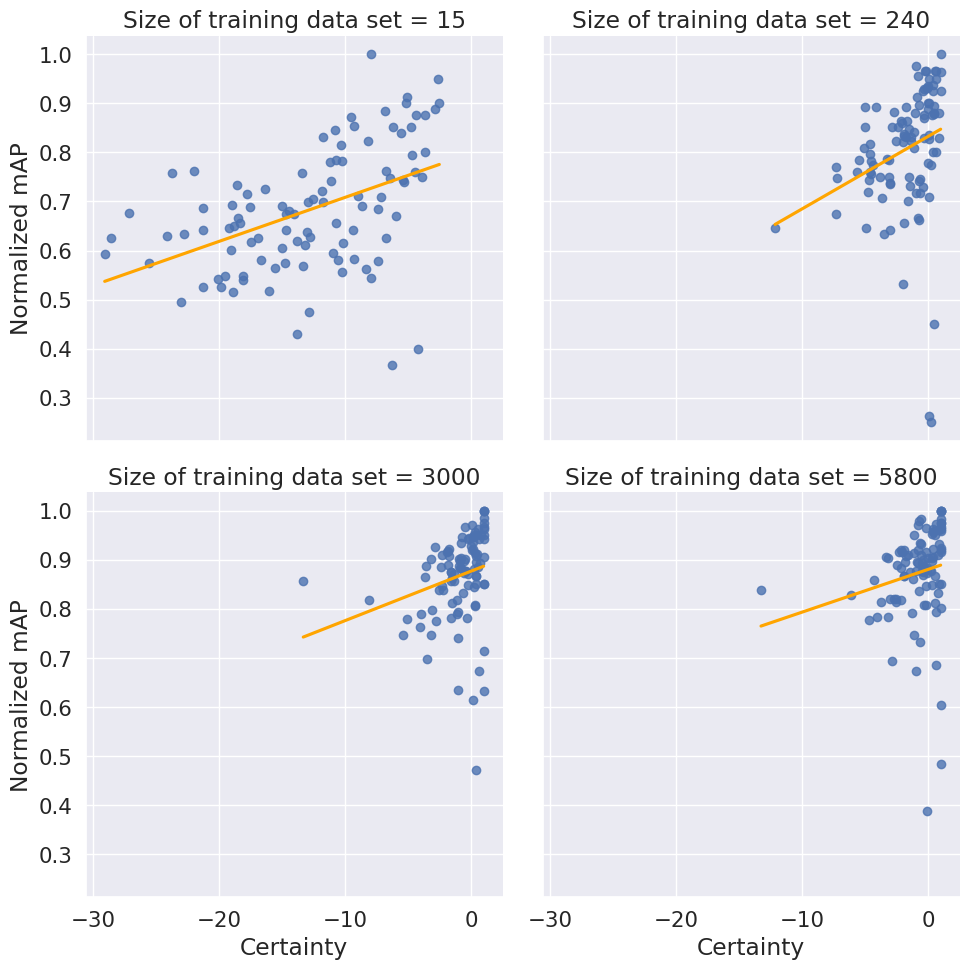

{'agg': 'sum', 'cut': False, 'mask_iou': True}


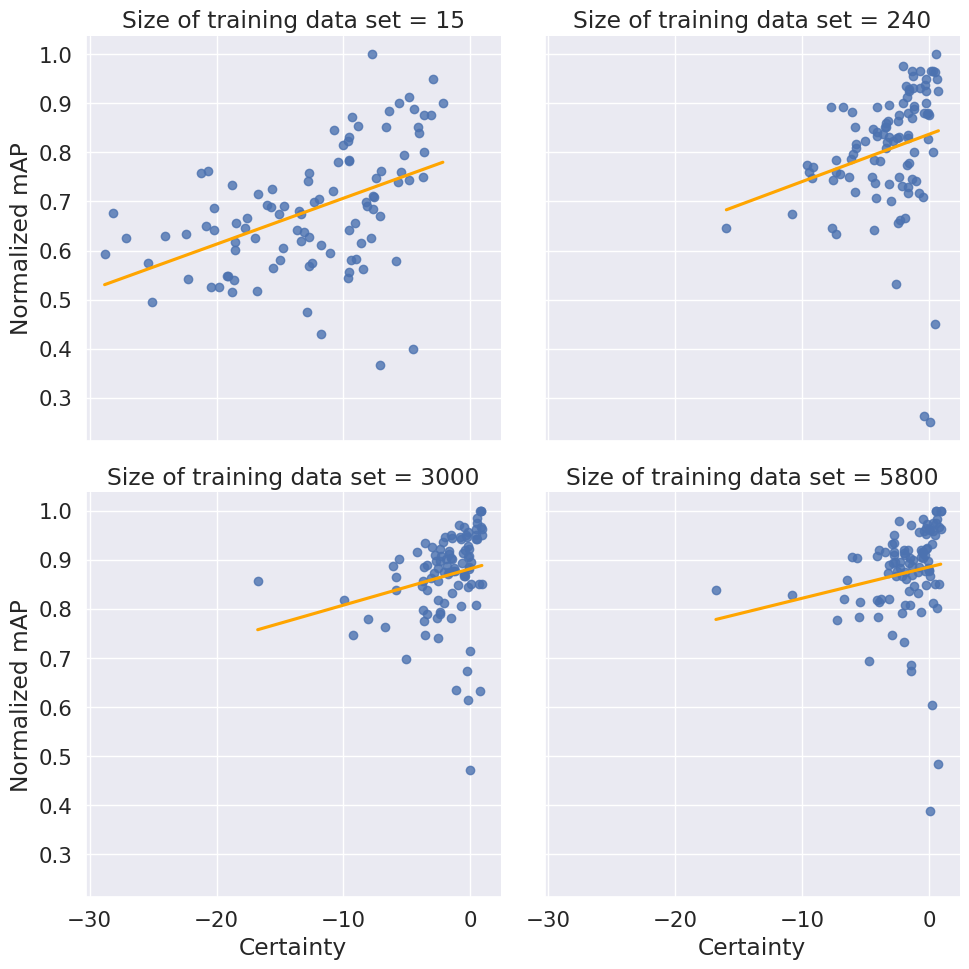

{'agg': 'sum', 'cut': False, 'mask_iou': False}


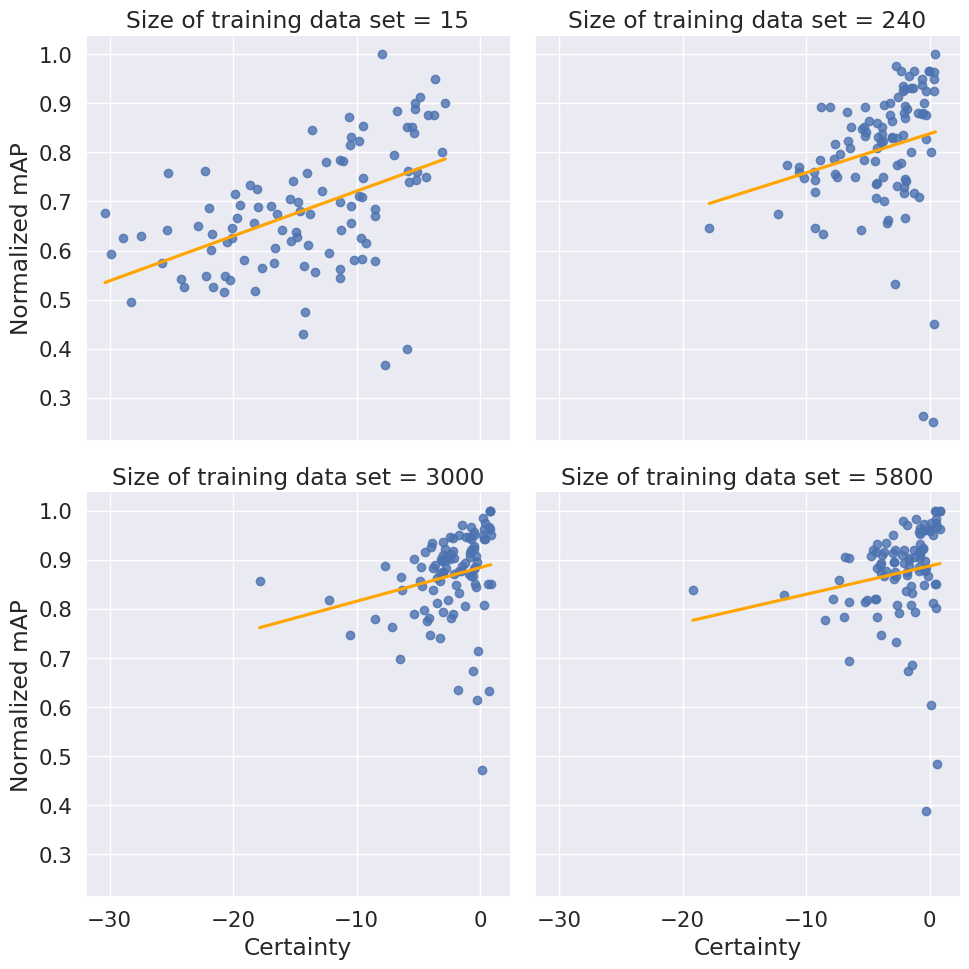

{'agg': 'max', 'cut': True, 'mask_iou': True}


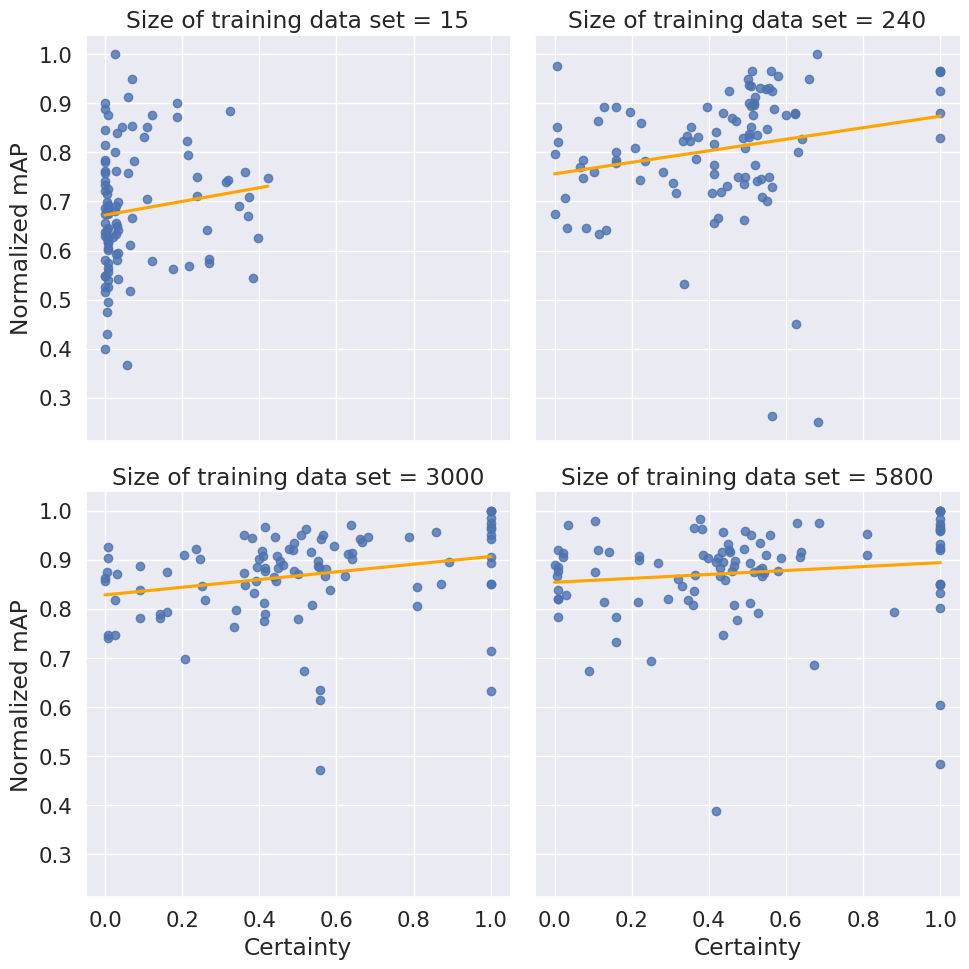

{'agg': 'max', 'cut': True, 'mask_iou': False}


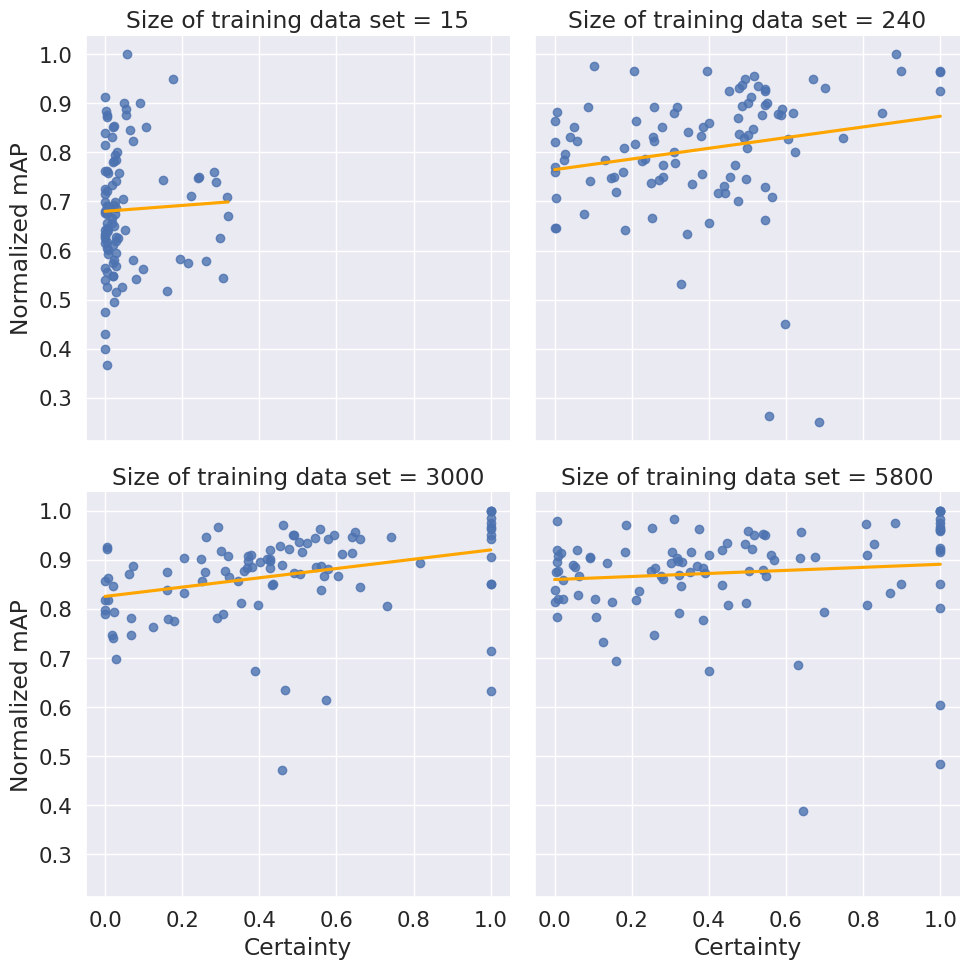

{'agg': 'max', 'cut': False, 'mask_iou': True}


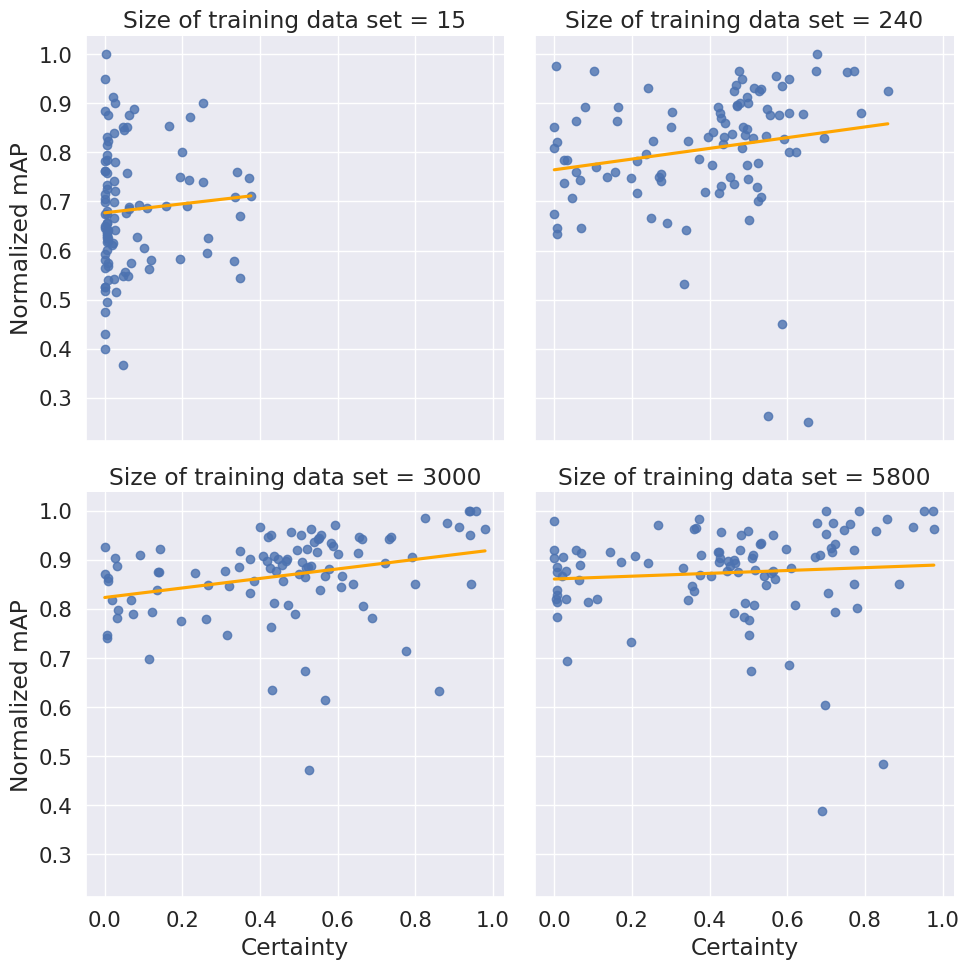

{'agg': 'max', 'cut': False, 'mask_iou': False}


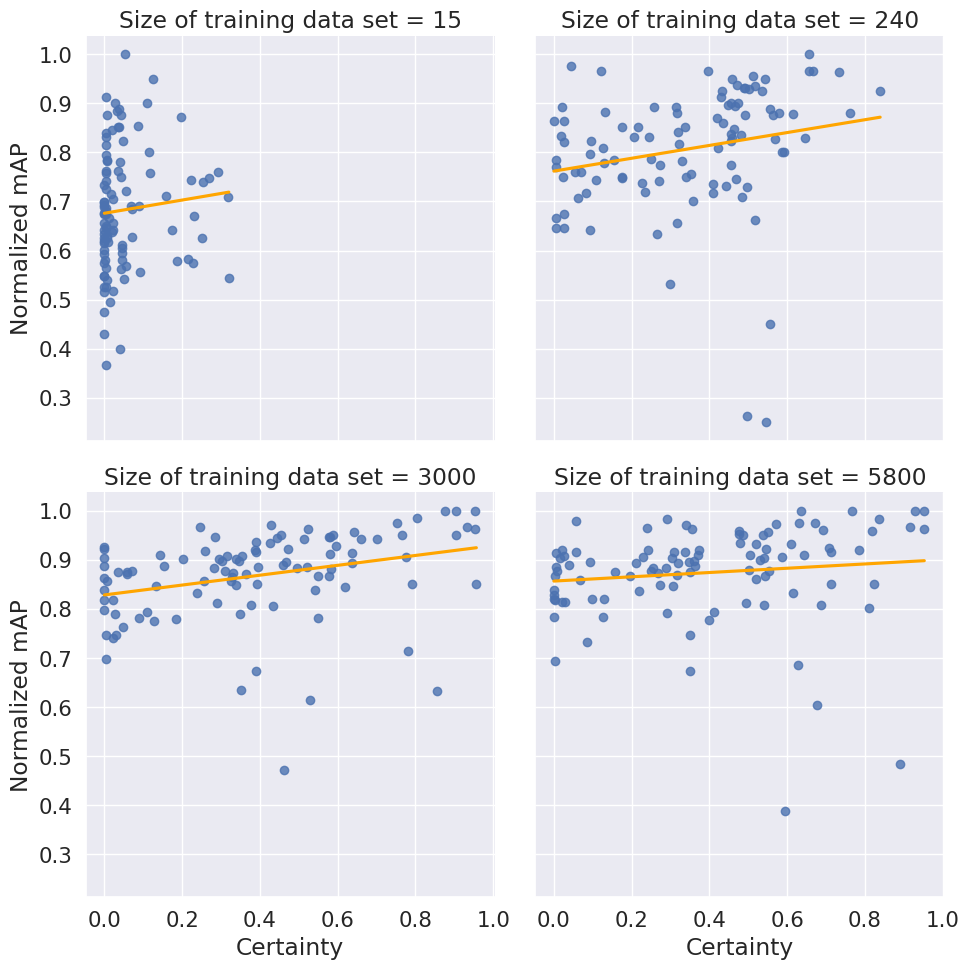

{'agg': 'mean', 'cut': True, 'mask_iou': True}


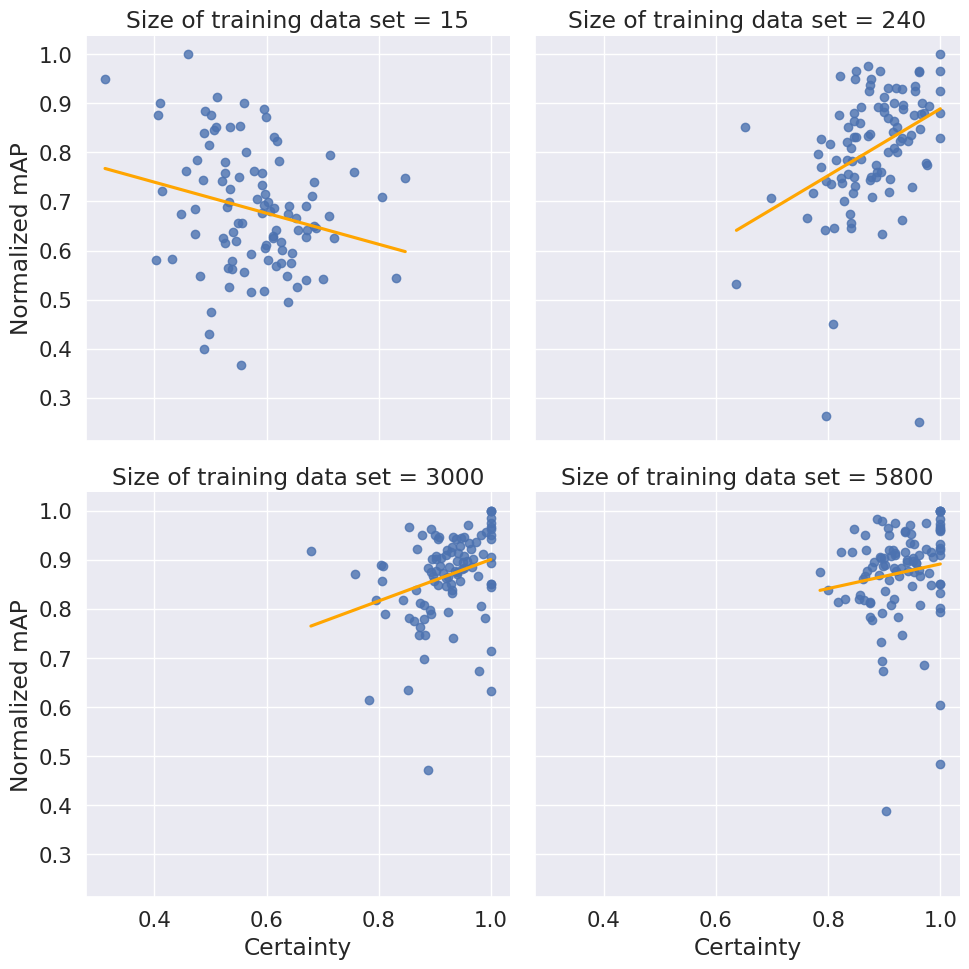

{'agg': 'mean', 'cut': True, 'mask_iou': False}


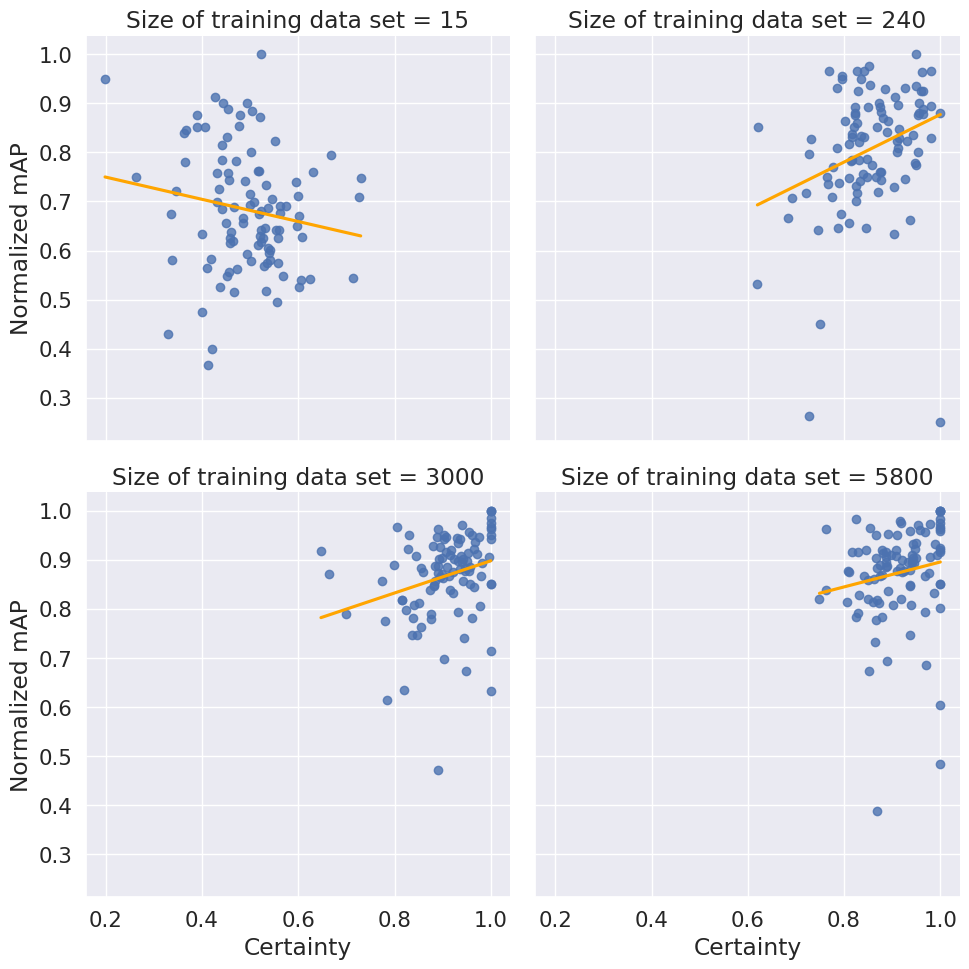

{'agg': 'mean', 'cut': False, 'mask_iou': True}


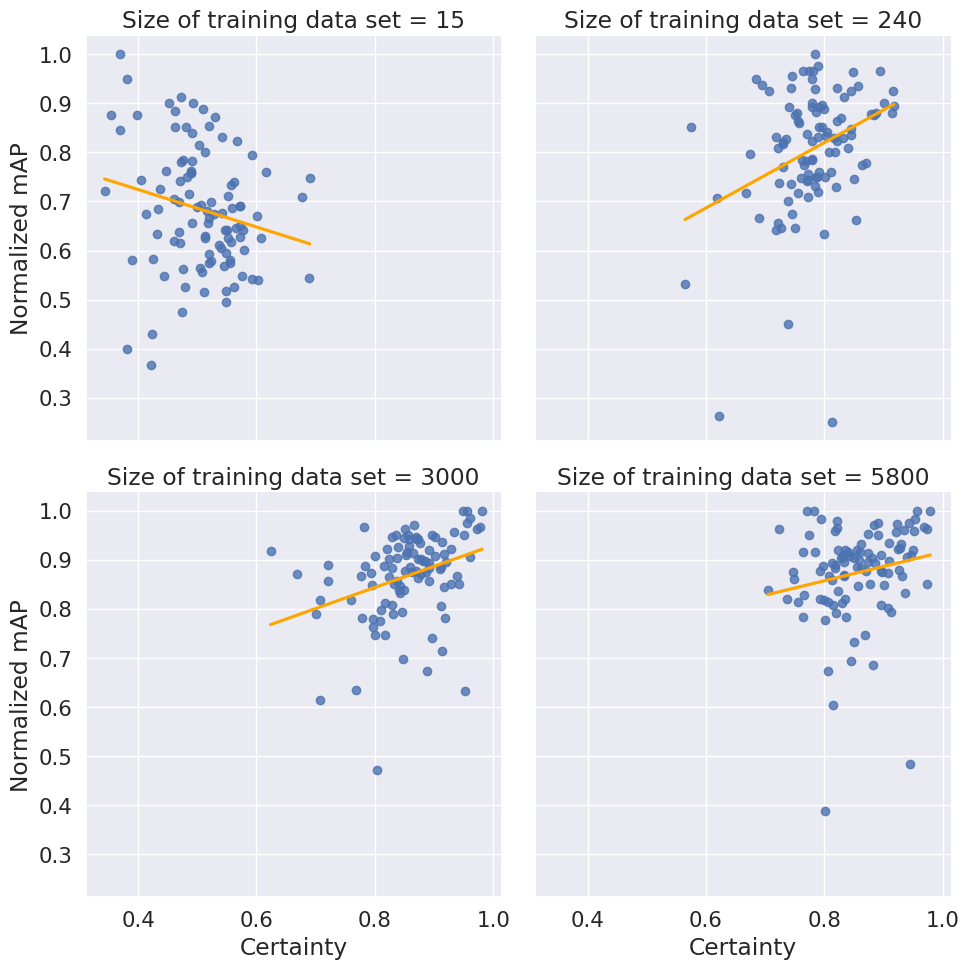

{'agg': 'mean', 'cut': False, 'mask_iou': False}


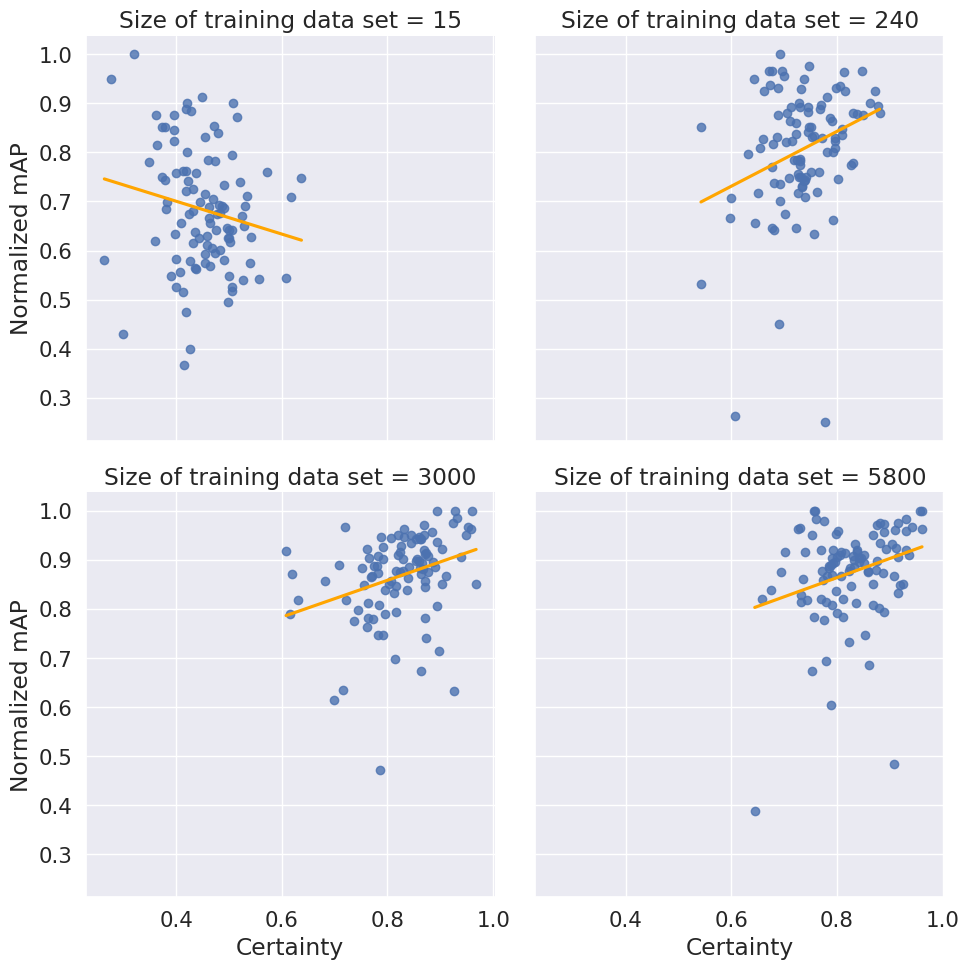

In [35]:

experiment_dir="mc_drop_aggregation"
filename = "mc_drop_agg"
agg_cols = ["cut","agg", "mask_iou", "model_train_size"]


get_experiment(path, experiment_dir, filename,  agg_cols)

file ignored: .ipynb_checkpoints
    num_mc_samples  max_noise  model_train_size      corr  neg_conf_gap  \
14              20       0.20                15  0.306518     -0.328979   
17              20       0.05               240  0.273445     -1.403411   
26              40       0.20                15  0.271945     -0.873915   
41              30       0.05               240  0.250530     -1.478814   
2               10       0.20                15  0.231480     -0.028109   
29              40       0.05               240  0.223353     -1.438352   
5               10       0.05               240  0.212978     -1.493178   
31              40       0.05              3000  0.170148     -0.367376   
38              30       0.20                15  0.150650     -0.769650   
39              30       0.20              3000  0.142465      0.000000   
43              30       0.05              3000  0.133773     -0.424707   
7               10       0.05              3000  0.126044     -0.28

/tmp/ipykernel_790120/976688089.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(index=False)
/tmp/ipykernel_790120/976688089.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex(index=False)
/tmp/ipykernel_790120/976688089.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is 

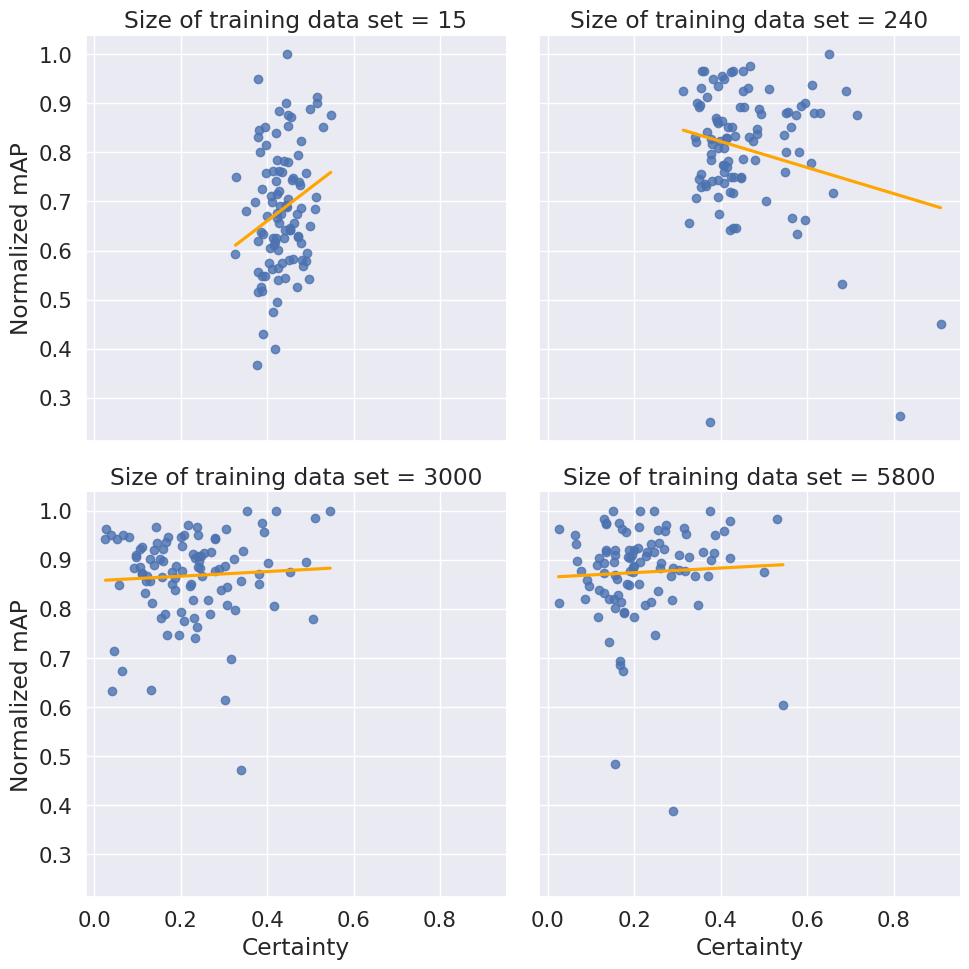

{'num_mc_samples': 10, 'max_noise': 0.05}


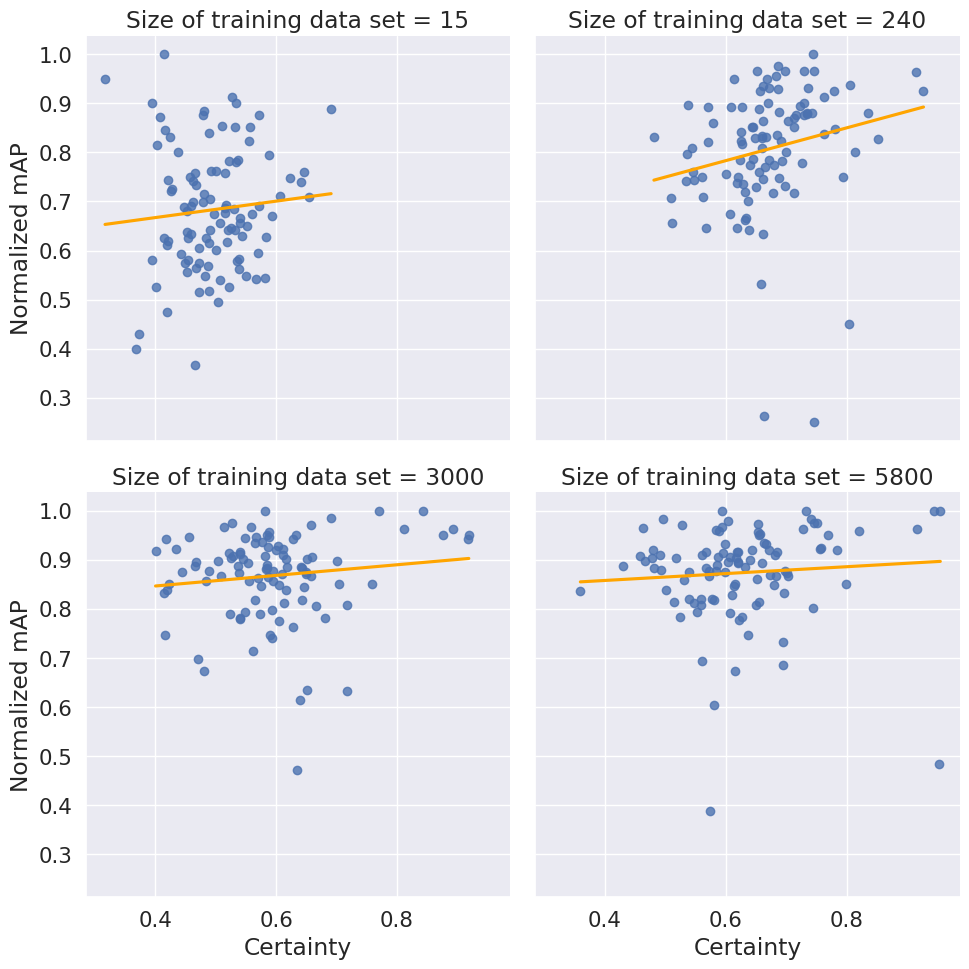

{'num_mc_samples': 10, 'max_noise': 0.1}


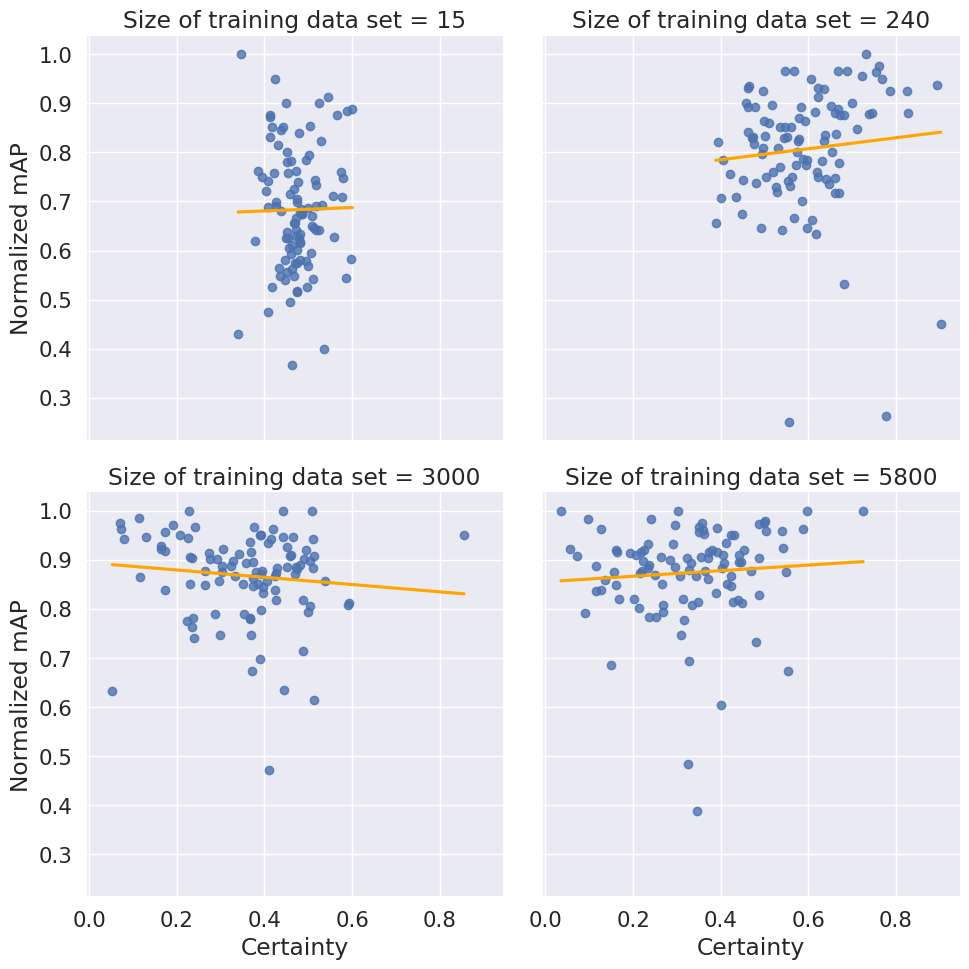

{'num_mc_samples': 20, 'max_noise': 0.2}


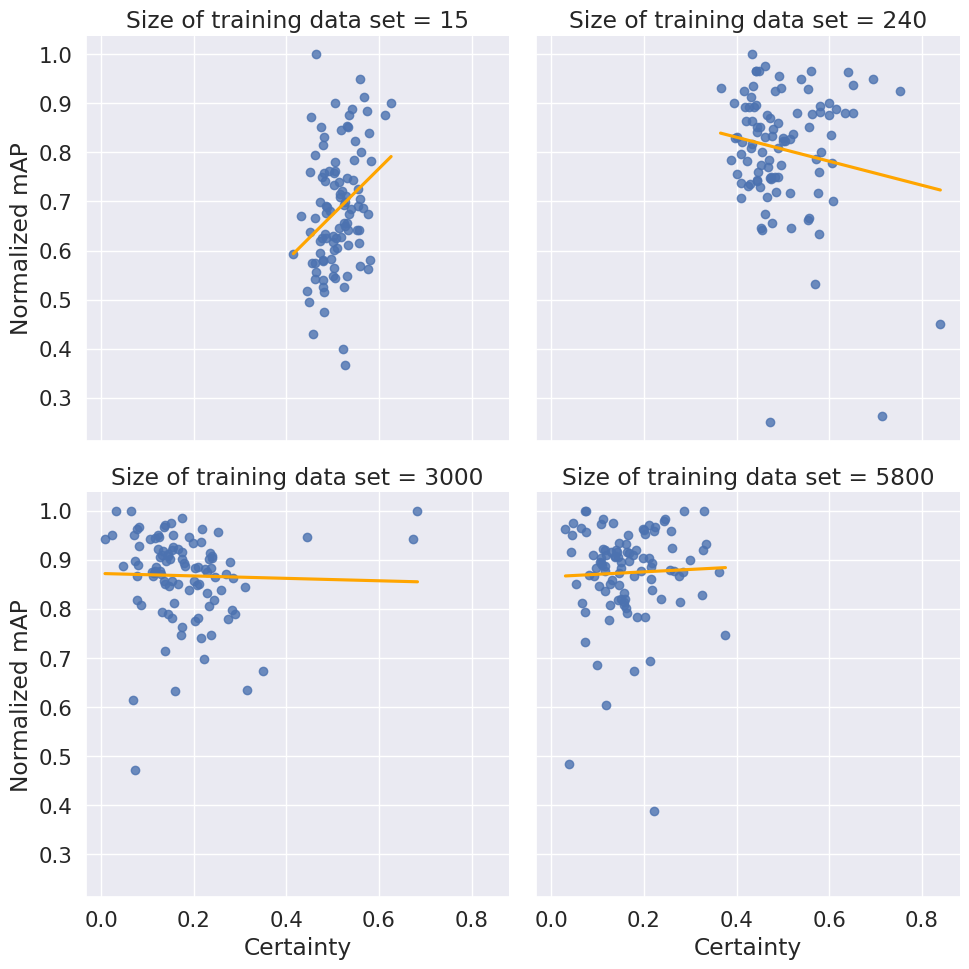

{'num_mc_samples': 20, 'max_noise': 0.05}


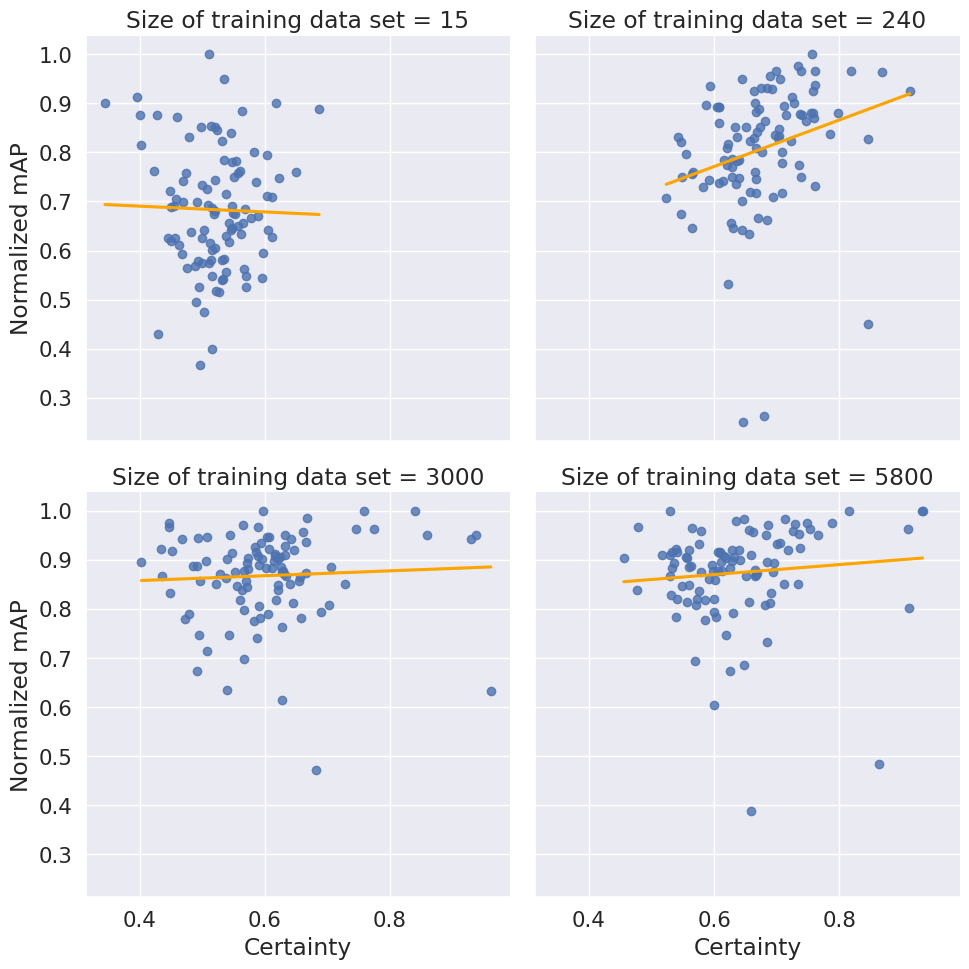

{'num_mc_samples': 20, 'max_noise': 0.1}


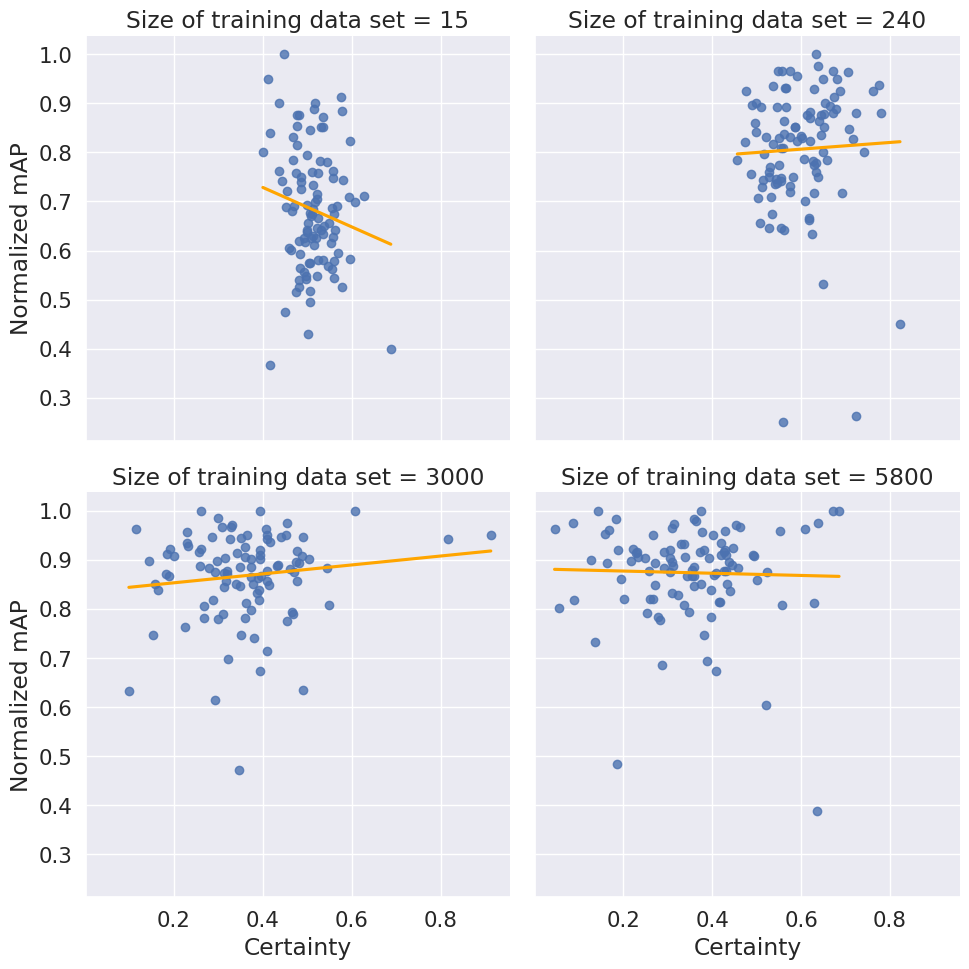

{'num_mc_samples': 40, 'max_noise': 0.2}


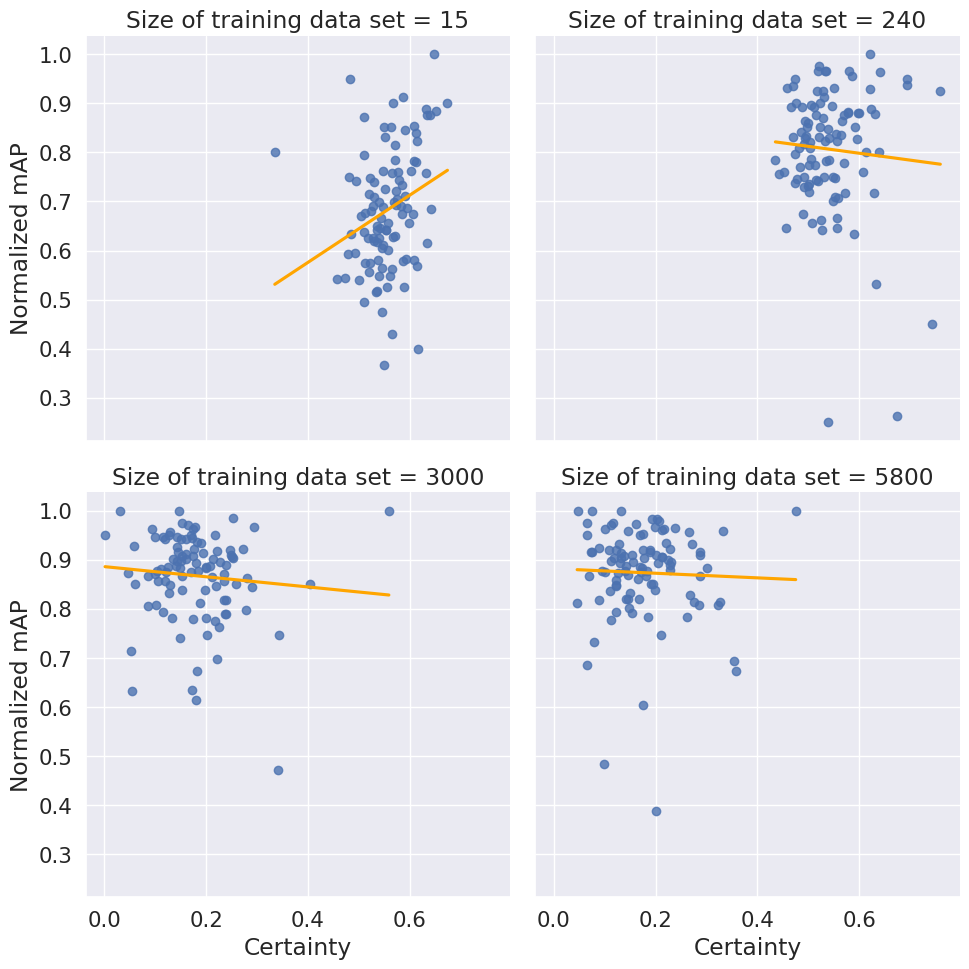

{'num_mc_samples': 40, 'max_noise': 0.05}


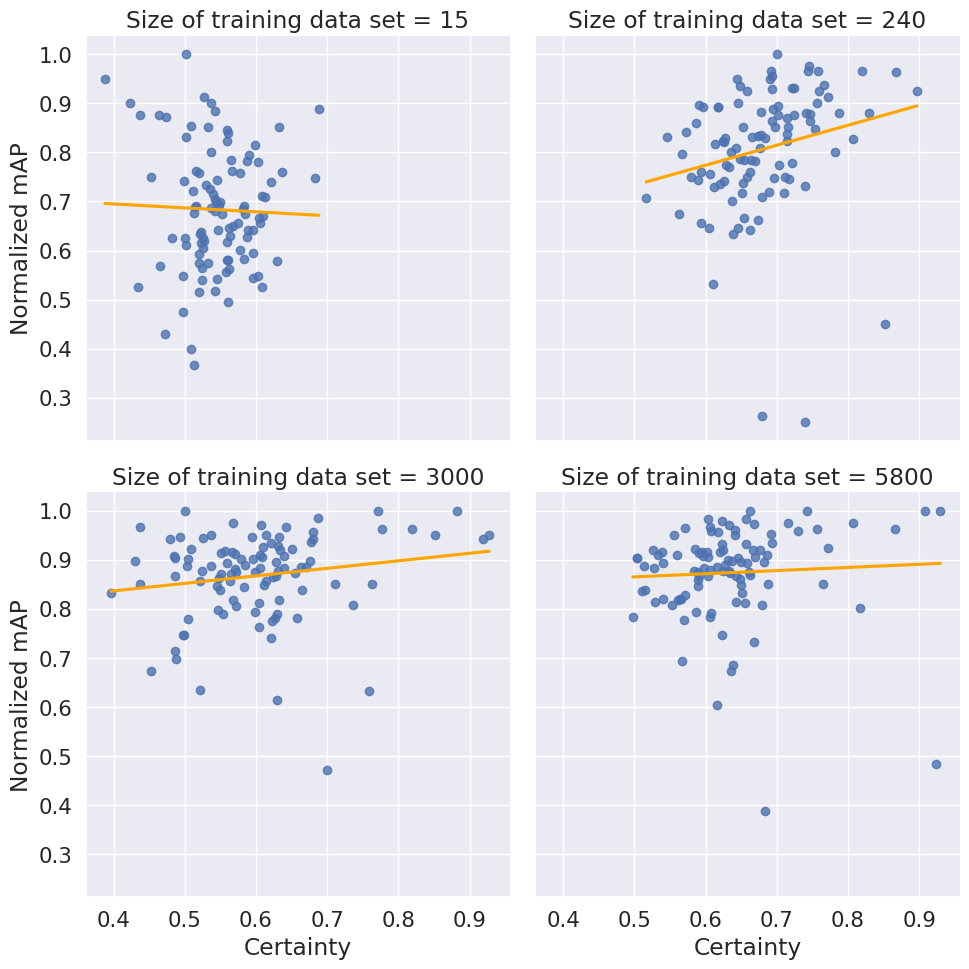

{'num_mc_samples': 40, 'max_noise': 0.1}


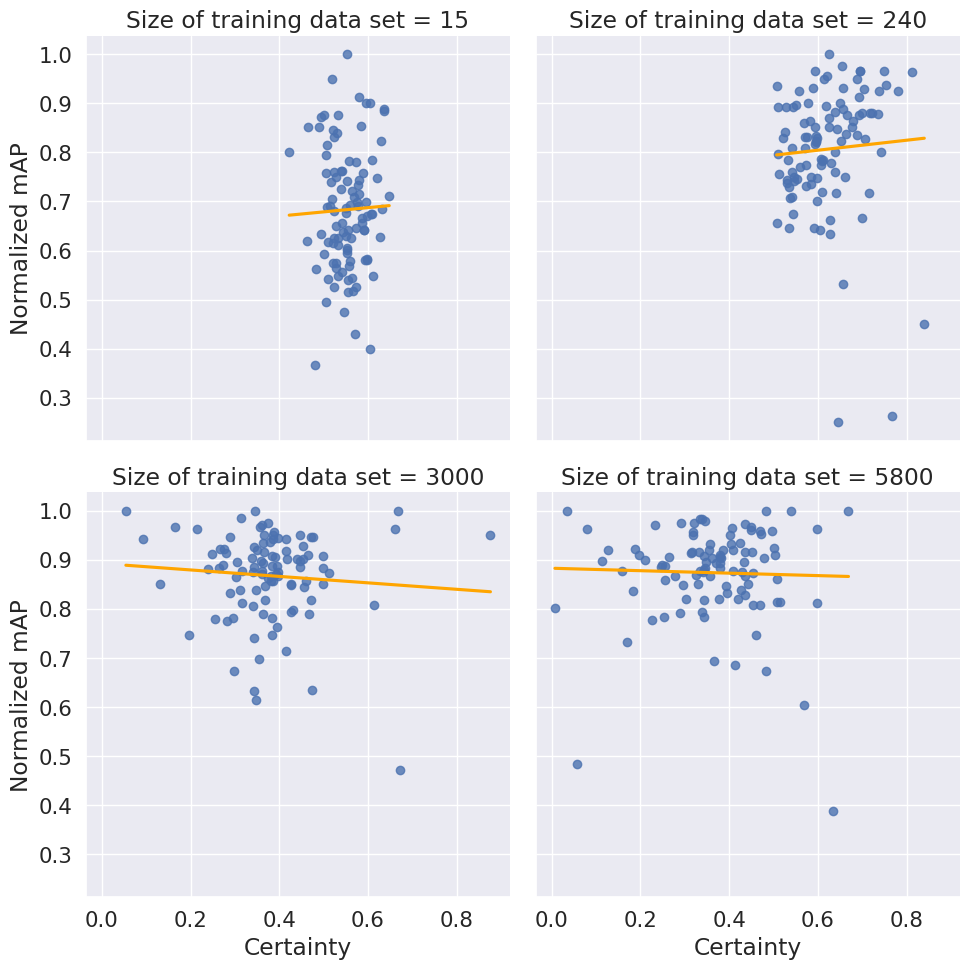

{'num_mc_samples': 30, 'max_noise': 0.2}


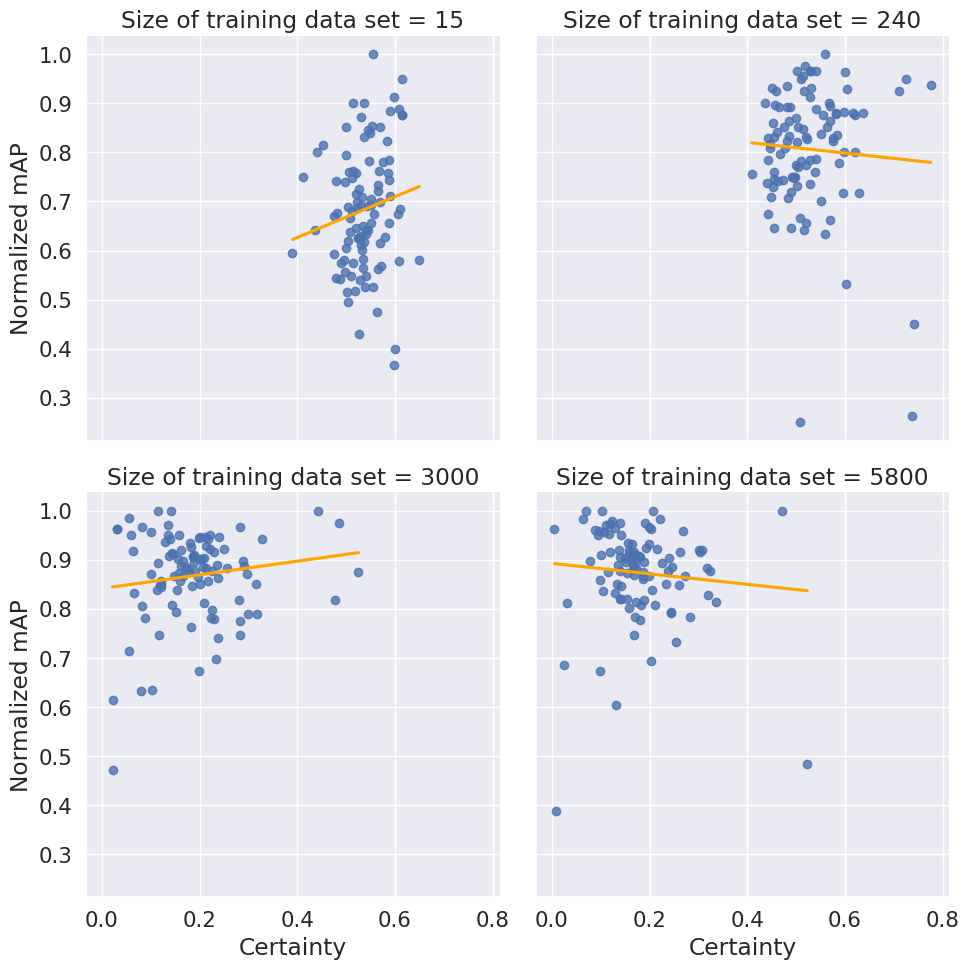

{'num_mc_samples': 30, 'max_noise': 0.05}


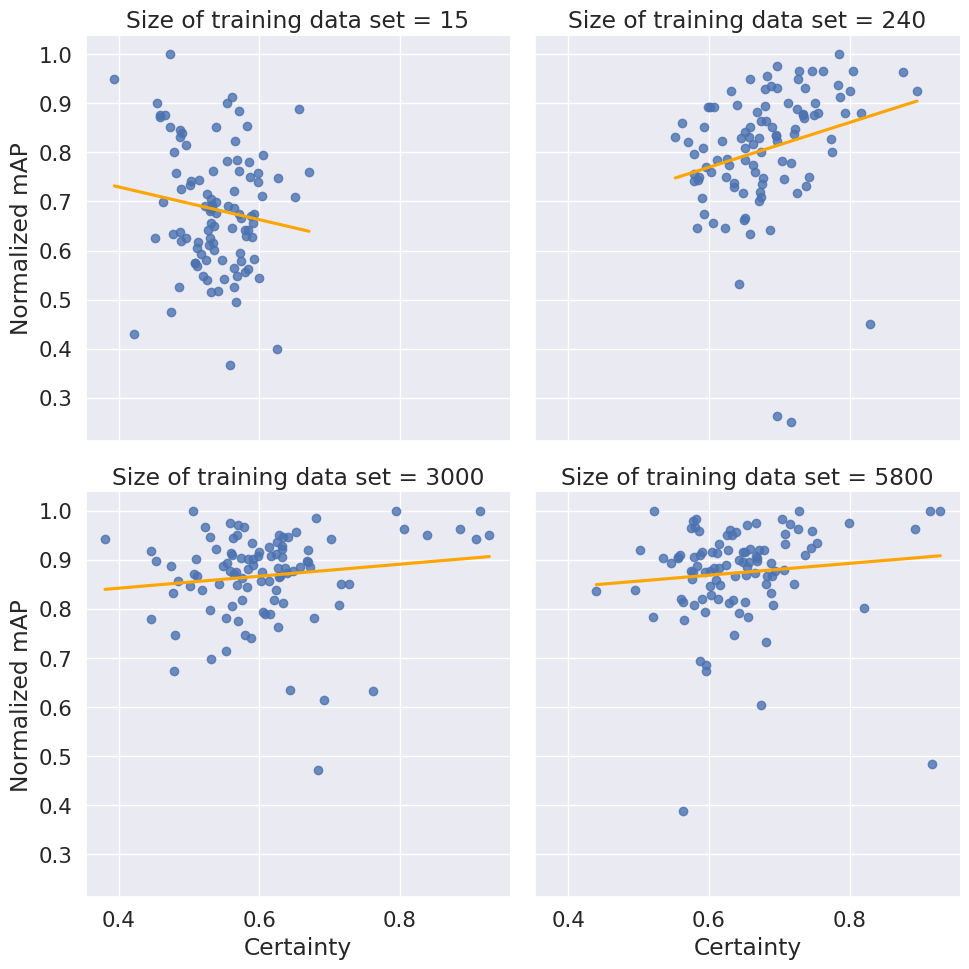

{'num_mc_samples': 30, 'max_noise': 0.1}


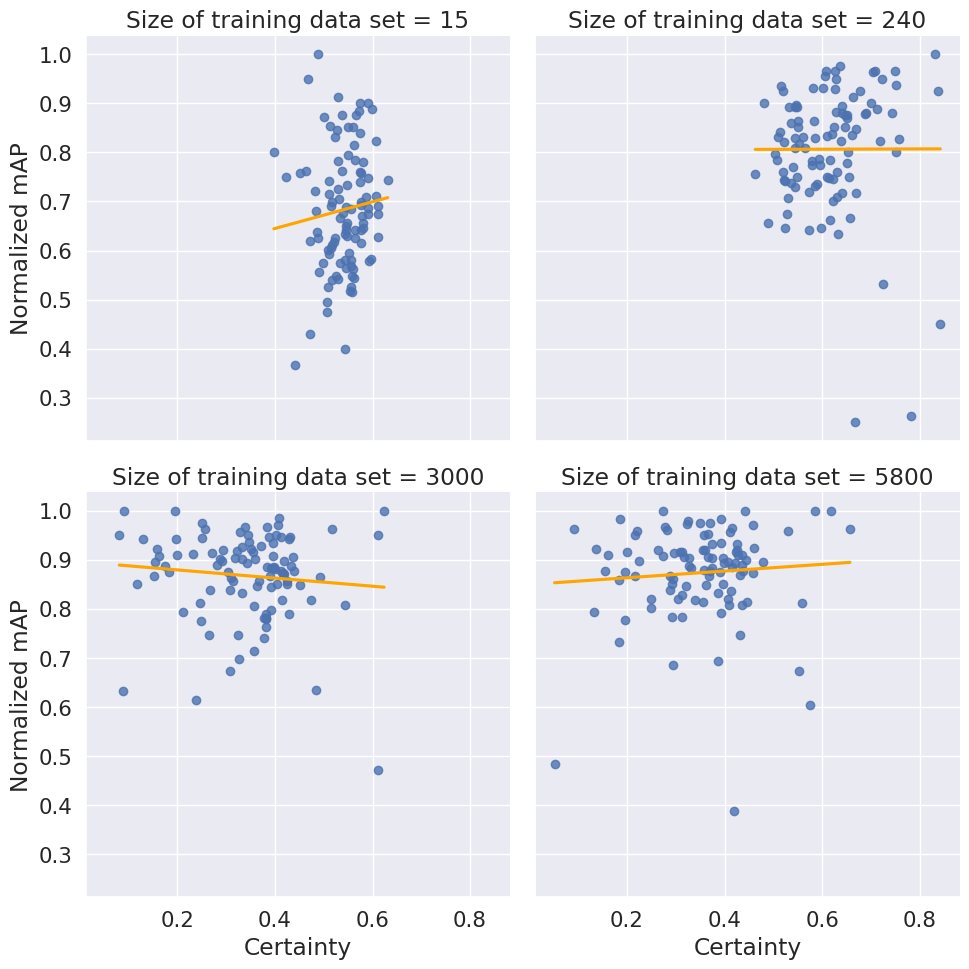

In [43]:

experiment_dir="tta_gridsearch"
filename = "tta_gridseach"
agg_cols = ["num_mc_samples","max_noise", "model_train_size"]

get_experiment(path, experiment_dir, filename,  agg_cols)